In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, HuberRegressor
import pickle
import itertools
import time
import ot
import os
from scipy.stats import rankdata, kendalltau, spearmanr
import seaborn as sns
from datetime import datetime
# from scipy.signal import savgol_filter
# from scipy.ndimage import gaussian_filter1d

In [2]:
alpha_arr = np.linspace(-0.5, 0.5, 51)*10.0

In [3]:
bench_zero = False

In [4]:
log_dir = './CobbDouglas_logs'
cali_dir = './CobbDouglas_cali'

In [5]:
plt.style.use('seaborn-v0_8-whitegrid')

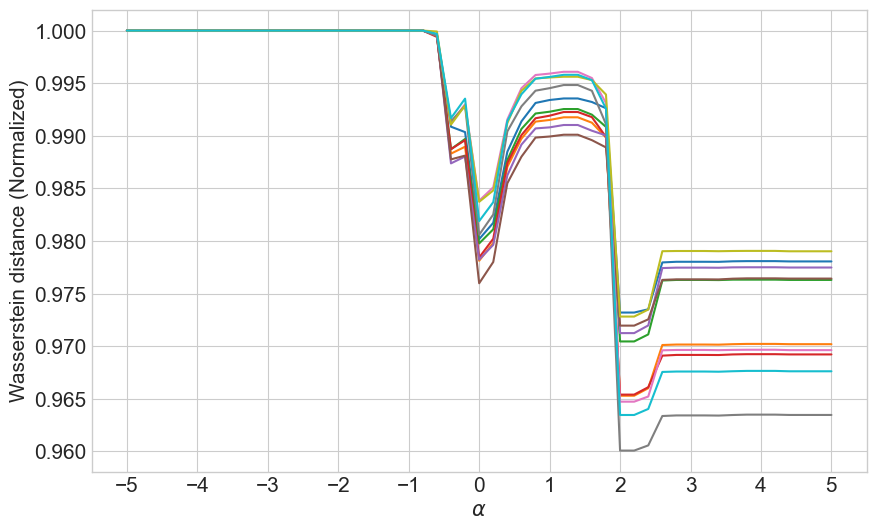

In [7]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
plt.figure(figsize=(10, 6))

for k in range(10):   
    sub_folder = "sim_{}_zero_{}".format(k, bench_zero)
    sub_dir = "{}/{}".format(cali_dir, sub_folder)

    with open('{}/sink_arr.pickle'.format(sub_dir), 'rb') as fp:
        sink = pickle.load(fp)
    plt.plot(alpha_arr, sink/sink[0])
    plt.xticks(np.arange(11) - 5)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel(r'$\alpha$', fontsize=15)
    plt.ylabel('Wasserstein distance (Normalized)', fontsize=15)   
plt.savefig('mismatched_corr.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [8]:
for k in range(10):
    sub_folder = "sim_{}_zero_{}".format(k, bench_zero)
    sub_dir = "{}/{}".format(cali_dir, sub_folder)

    with open('{}/sink_arr.pickle'.format(sub_dir), 'rb') as fp:
        sink = pickle.load(fp)

    cand = np.where(sink == sink.min())[0]
    min_id = cand[np.argmin(np.abs(cand-25))]
    print(min_id, alpha_arr[min_id])

36 2.1999999999999997
35 2.000000000000001
35 2.000000000000001
35 2.000000000000001
35 2.000000000000001
36 2.1999999999999997
35 2.000000000000001
35 2.000000000000001
35 2.000000000000001
35 2.000000000000001


In [9]:
dir_wage = './CobbDouglas_logs/zero_False/sim_9_alpha_35'

with open('{}/wage_init.pickle'.format(dir_wage), 'rb') as fp:
    wage_init = pickle.load(fp)
    
with open('{}/ot_init.pickle'.format(dir_wage), 'rb') as fp:
    ot_init = pickle.load(fp)

In [10]:
wage_init

array([1.05901169, 0.75973604, 0.60670869, 0.52312454, 0.39579242])

In [11]:
np.round(wage_init - np.min(wage_init), 3)

array([0.663, 0.364, 0.211, 0.127, 0.   ])

In [12]:
# number of paired firm-worker with nonzero prob
num_cell = np.where(ot_init > 0)[0].shape[0]
firm_idx = np.zeros(num_cell)
worker_rank = np.zeros(num_cell)
worker_salary = np.zeros(num_cell)
pair_prob =  np.zeros(num_cell)

In [13]:
# inital wage
tmp_id = 0
for f_idx in range(5):
    for w_idx in range(5):
        if ot_init[f_idx, w_idx] > 0:
            firm_idx[tmp_id] = f_idx
            worker_rank[tmp_id] = w_idx
            worker_salary[tmp_id] = wage_init[w_idx] - np.min(wage_init)
            pair_prob[tmp_id] = ot_init[f_idx, w_idx]
            tmp_id += 1
            print(f_idx, w_idx, wage_init[w_idx], ot_init[f_idx, w_idx])
            # print(wage_init - np.min(wage_init))

0 0 1.0590116932835394 0.125
1 0 1.0590116932835394 0.07500000000000001
1 1 0.7597360413378742 0.175
2 1 0.7597360413378742 0.025000000000000022
2 3 0.5231245389984989 0.19999999999999996
2 4 0.39579242254603253 0.025000000000000022
3 2 0.6067086881502459 0.2
3 4 0.39579242254603253 0.04999999999999999
4 4 0.39579242254603253 0.125


In [14]:
# average salary
(pair_prob*worker_salary).sum()

0.2730822543172057

In [15]:
ot_init

array([[0.125, 0.   , 0.   , 0.   , 0.   ],
       [0.075, 0.175, 0.   , 0.   , 0.   ],
       [0.   , 0.025, 0.   , 0.2  , 0.025],
       [0.   , 0.   , 0.2  , 0.   , 0.05 ],
       [0.   , 0.   , 0.   , 0.   , 0.125]])

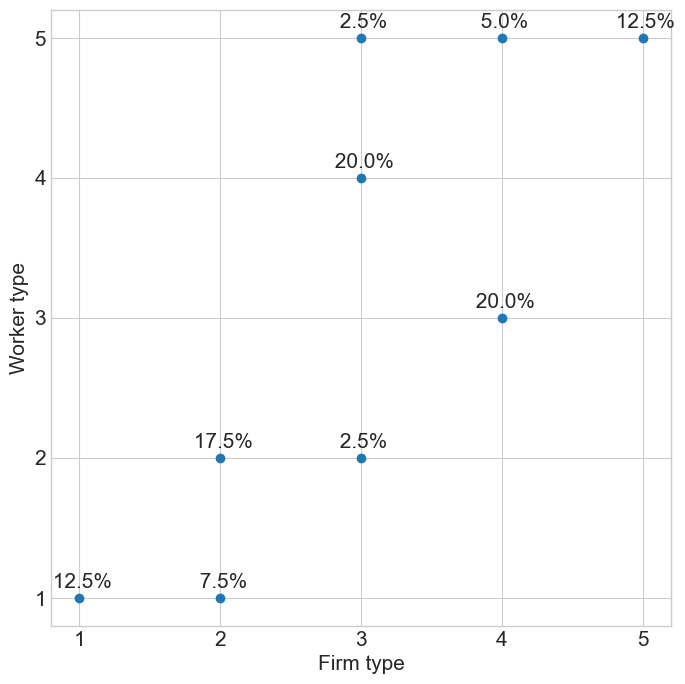

In [16]:
plt.figure(figsize=(8, 8))
plt.plot(firm_idx+1, worker_rank+1, '.', markersize=12)
plt.xticks(np.arange(5)+1)
plt.yticks(np.arange(5)+1)
tmp_ = 0
for x, y in zip(firm_idx+1, worker_rank+1):
    plt.text(x, y+0.04, ' {:.1f}%'.format(pair_prob[tmp_]*100), fontsize=15, horizontalalignment='center', verticalalignment='bottom')
    tmp_ += 1
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Firm type', fontsize=15)
plt.ylabel('Worker type', fontsize=15)   
plt.savefig('mismatched_firm_worker.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)

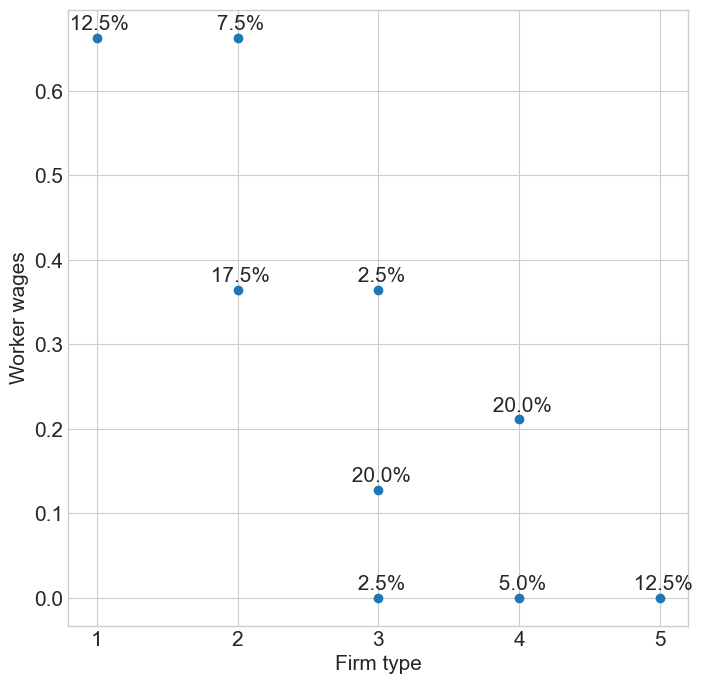

In [17]:
plt.figure(figsize=(8, 8))
plt.plot(firm_idx+1, worker_salary, '.', markersize=12)
plt.xticks(np.arange(5)+1)
# plt.yticks(np.arange(5)+1)
tmp_ = 0
for x, y in zip(firm_idx+1, worker_salary):
    plt.text(x, y+0.005, ' {:.1f}%'.format(pair_prob[tmp_]*100), fontsize=15, horizontalalignment='center', verticalalignment='bottom')
    tmp_ += 1
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Firm type', fontsize=15)
plt.ylabel('Worker wages', fontsize=15)   
plt.savefig('mismatched_firm_salary.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)

## Some statistical fact of data

In [18]:
from sklearn.linear_model import LinearRegression
# Roberts' law, but depends on wage levels up to a constant
firm_size = 1/(np.arange(5)+1)
reg = LinearRegression().fit(np.log(firm_size).reshape(-1, 1), np.log(wage_init + 0.5))
reg.coef_

array([0.33045828])

In [19]:
# Kendall's tau of observed path
obs_path = np.array([[0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
                     [0., 1., 0., 0., 0., 1., 0., 2., 0., 3.],
                     [1., 0., 1., 1., 1., 0., 1., 1., 1., 2.],
                     [1., 3., 2., 3., 1., 3., 1., 2., 2., 3.],
                     [2., 0., 2., 2., 2., 2., 2., 1., 2., 1.],
                     [2., 3., 1., 2., 2., 1., 2., 0., 1., 1.],
                     [3., 2., 3., 0., 3., 3., 3., 3., 3., 0.],
                     [3., 4., 3., 4., 4., 4., 4., 3., 4., 4.],
                     [4., 2., 4., 3., 4., 2., 3., 4., 4., 2.]])

kendalltau(obs_path.reshape(-1)[::2], obs_path.reshape(-1)[1::2])

SignificanceResult(statistic=0.4034897399232415, pvalue=0.0008836886464014808)

In [20]:
with open('{}/value_func.pickle'.format(dir_wage), 'rb') as fp:
    value_func = pickle.load(fp)

In [21]:
value_func[0, :, :]

array([[-2.58065636, -2.43131592, -2.31042689, -2.20495815, -2.10964885],
       [-1.23102748, -1.15635726, -1.09302927, -0.95910449, -0.88231827],
       [-1.00426928, -0.99253422, -0.95512134, -0.9901926 , -0.95842283],
       [-0.63162961, -0.5942945 , -0.56407224, -0.52329048, -0.50305727],
       [-0.53754605, -0.50563015, -0.49586693, -0.47477318, -0.45571132]])

In [22]:
cost_mat = np.zeros((5, 5))
for i in range(5):
    for j in range(5):
        cost_mat[i, j] = -1/(i+1)*(5**0.6 - (j+1)**0.6)

In [23]:
cost_mat

array([[-1.6265278 , -1.11081124, -0.69334576, -0.32913109, -0.        ],
       [-0.8132639 , -0.55540562, -0.34667288, -0.16456555, -0.        ],
       [-0.54217593, -0.37027041, -0.23111525, -0.10971036, -0.        ],
       [-0.40663195, -0.27770281, -0.17333644, -0.08228277, -0.        ],
       [-0.32530556, -0.22216225, -0.13866915, -0.06582622, -0.        ]])

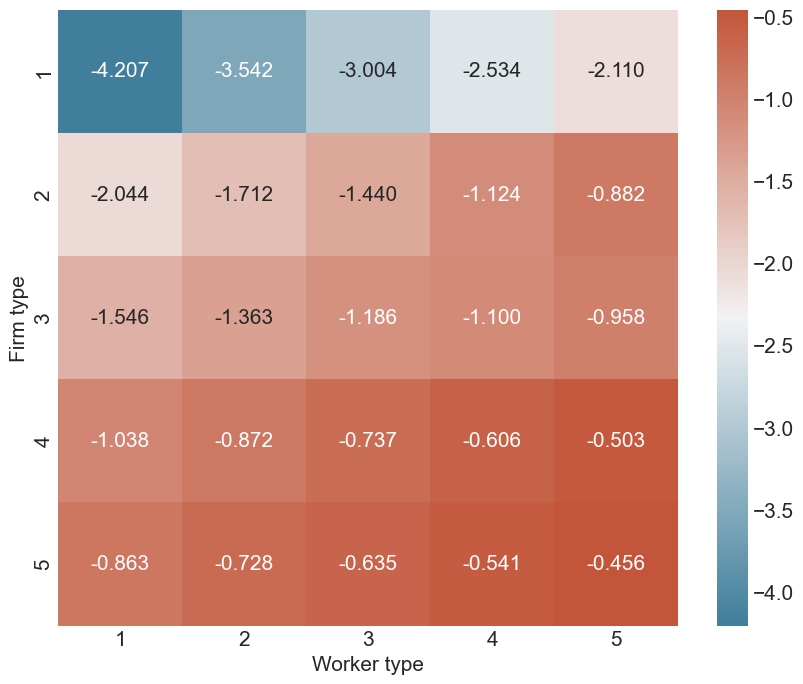

In [24]:
x_shape = 5
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cost_mat + value_func[0, :, :], xticklabels=np.arange(1, x_shape+1),
                 yticklabels=np.arange(1, x_shape+1),
                 annot=True, fmt=".3f", annot_kws={"fontsize": 15}, cmap=cmap)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Worker type', fontsize=15)
plt.ylabel('Firm type', fontsize=15)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
plt.savefig('mismatched_cost.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [25]:
surplus = - cost_mat - value_func[0, :, :]
for i in range(5):
    for i_p in range(i, 5):
        for j in range(5):
            for j_p in range(j, 5):
                if surplus[i, j] + surplus[i_p, j_p] < surplus[i, j_p] + surplus[i_p, j]:
                    print('supermodular property failed at', i, i_p, j, j_p)

supermodular property failed at 2 3 1 3
supermodular property failed at 2 3 2 3
supermodular property failed at 2 3 2 4
supermodular property failed at 2 4 2 3


In [26]:
surplus[0, 1]

3.5421271621069734

In [27]:
worker_trans = np.array([[0.4, 0.15, 0.15, 0.15, 0.15], [0.15, 0.4, 0.15, 0.15, 0.15],
                         [0.15, 0.15, 0.4, 0.15, 0.15], [0.15, 0.15, 0.15, 0.4, 0.15],
                         [0.15, 0.15, 0.15, 0.15, 0.4]])

firm_trans = np.array([[10., 0., 0., 0., 0.], [0., 14., 6., 0., 0.],
                       [0., 6., 14., 0., 0.], [0., 0., 0., 18., 2.],
                       [0., 0., 0., 1., 9.]])
firm_dist = firm_trans.sum(axis=1)/firm_trans.sum()
worker_dist = worker_trans.sum(axis=1)/worker_trans.sum()

min_obj = cost_mat + value_func[0, :, :]

res_init = ot.emd(firm_dist, worker_dist, min_obj, log=True)
res_init[1]['v']

array([-1.17667966, -0.84415116, -0.67412076, -0.58124949, -0.43976936])

In [28]:
res_init[1]['u']

array([-3.03050451, -0.86761172, -0.51865347, -0.06328792, -0.01594196])

In [29]:
min_obj

array([[-4.20718417, -3.54212716, -3.00377265, -2.53408924, -2.10964885],
       [-2.04429138, -1.71176288, -1.43970215, -1.12367004, -0.88231827],
       [-1.54644521, -1.36280463, -1.1862366 , -1.09990296, -0.95842283],
       [-1.03826156, -0.87199731, -0.73740868, -0.60557325, -0.50305727],
       [-0.86285162, -0.7277924 , -0.63453608, -0.5405994 , -0.45571132]])